# Functions

## construct encoder

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import regularizers
from keras import backend as K

In [2]:
print(keras.__version__)

2.4.3


In [4]:
def encoder_constructor_vary_t2s(latent_dim, TE, scale_factor_t2_amp, signal_model):
    """construct sled model"""
    # initilize the input layer for encoder
    keras.backend.clear_session()
    encoder_input = keras.Input(shape=(TE.shape[0],)) 

    
    # t2_loc encoding for myelin water pool
    t2s_loc_my = layers.Dense(256, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(encoder_input)
    layers.BatchNormalization()
    t2s_loc_my = layers.Dense(128, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_loc_my)
    t2s_loc_my = layers.Dense(1, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_loc_my)*0.01+0.005
    # t2_loc encoding for axnoal water pool
    t2s_loc_ax = layers.Dense(256, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(encoder_input)
    layers.BatchNormalization()
    t2s_loc_ax = layers.Dense(128, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_loc_ax)
    t2s_loc_ax = layers.Dense(1, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_loc_ax)*0.015 + 0.045
    # t2_loc encoding for free water pool
    t2s_loc_ex = layers.Dense(256, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(encoder_input)
    layers.BatchNormalization()
    t2s_loc_ex = layers.Dense(128, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_loc_ex)
    t2s_loc_ex = layers.Dense(1, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_loc_ex)*0.1 + 0.2
    
    t2s_loc = tf.concat([t2s_loc_my, t2s_loc_ax, t2s_loc_ex],1)
    
    # t2_amp encoding
    t2s_amp = layers.Dense(256, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(encoder_input)
    layers.BatchNormalization()
#     t2s_amp = layers.Dense(256, activation='sigmoid', 
#                            kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_amp)
#     layers.BatchNormalization()
    t2s_amp = layers.Dense(256, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_amp)
    t2s_amp = layers.Dense(latent_dim, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_amp)*scale_factor_t2_amp
    
    # construct the model
    encoder = keras.Model(encoder_input, [t2s_loc, t2s_amp], name='encoder')
    output = layers.Lambda(signal_model)([t2s_loc, t2s_amp, TE])
    model = keras.Model(encoder_input, output, name='encoder_decoder')
    
    return encoder, model

In [6]:
def signal_model_vpools(args):
    """Signal model (arbitrary number of pools) for multi-echo gradient echo MWI data"""
    # load the parameters and reshape for later calculations (first axis reserved for the size of input data)
    T2_location, T2_amplitude, TE = args
    T2_location = T2_location[:,tf.newaxis,:]
    T2_amplitude = T2_amplitude[:,:,tf.newaxis]
    TE = TE[tf.newaxis,:,tf.newaxis]
    
    # calculate the kernel matrix for the fitting and generate the signal 
    kernel_matrix = K.exp(-TE/T2_location)
    signal = tf.squeeze(tf.linalg.matmul(kernel_matrix, T2_amplitude))
    
    # random noise
    #SNR = np.random.uniform(50,300) # used to be [100, 300]
    SNR = tf.random.uniform((tf.shape(signal)[0],1), 50, 300) # randomly pick snr for each training example
    scale_factor = tf.reduce_mean(signal, 0)[0] # use the mean intensity of the first echo as the reference
    variance = scale_factor*1/(SNR * np.sqrt(np.pi/2))
    noise_real = tf.random.normal(tf.shape(signal), 0, variance) # tf.shape used here to handle 'None' shape
    noise_img = tf.random.normal(tf.shape(signal), 0, variance)
#     noise_mag = (noise_real**2 + noise_img**2)**0.5
#     signal =  signal + noise_mag
    noisy_signal = ((noise_real+signal)**2 + noise_img**2)**0.5 # assume signal is all real
    
    return noisy_signal

## load and preprocess data

In [7]:
import nibabel as nib
import matplotlib.pyplot as plt

In [17]:
def load_data(image_path, mask_path, ETL=24):
    """load nifti dataset and brain mask, return masked image as numpy array"""
    image =  nib.load(image_path).get_fdata()
    mask = nib.load(mask_path).get_fdata()
    mask_4d = np.repeat(mask[:, :, :, np.newaxis], ETL, axis=3)
    mask_4d[mask_4d==0] = np.nan
    masked_image = image*mask_4d
    
    return image, mask, masked_image

In [18]:
def preprocess_data(data):
    """flaten 4D dataset and normalize"""
    data_flat = data.reshape(-1, data.shape[-1])
    data_flat = data_flat[~np.isnan(data_flat)].reshape(-1, data_flat.shape[1])
    data_flat_norm = data_flat/(data_flat[:,0].reshape(data_flat.shape[0],1))
    data_flat_norm = data_flat_norm.astype('float32')

    return data_flat, data_flat_norm

## model training

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
def train_model(model, data, partition_factor = 0, epochs = 30):
    """compile and fit sled model"""
    if partition_factor == 0:
        model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, clipnorm=1, clipvalue=1), loss='mse')
        callbacks_list = [keras.callbacks.EarlyStopping(monitor='loss', patience=15),
                          #keras.callbacks.ModelCheckpoint(filepath='NN_model_example.h5',monitor='val_loss',save_best_only=True),
                          keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3)]
        model.fit(data, data, epochs=epochs, 
                  batch_size=256, 
                  callbacks=callbacks_list)

    else:
        ### split the dataset into training and validation sets
        x_train, x_val, y_train, y_val = train_test_split(data, data, test_size = partition_factor, random_state=10)
        model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, clipnorm=1, clipvalue=1), loss='mse', run_eagerly=True)
        callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),
                          #keras.callbacks.ModelCheckpoint(filepath='NN_model_example.h5',monitor='val_loss',save_best_only=True),
                          keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3)]
        model.fit(x_train, y_train, epochs=epochs, 
                  batch_size=128, 
                  callbacks=callbacks_list, validation_data=(x_val, y_val))
    

## apply model

In [19]:
def fitting_plots(model, data, TE, plots=[2, 5], size=(20, 10)):
    """plot the fitting results for randomly selected voxels"""
    plt.figure(figsize=size)
    index_list = np.random.randint(0, data.shape[0], plots)
    plots_num = 1
    for i in range(index_list.shape[0]):
        for j in range(index_list.shape[1]):
            plt.subplot(plots[0], plots[1], plots_num) 
            plt.plot(TE, np.squeeze(model.predict(data[index_list[i,j]:index_list[i,j]+1,:])))
            plt.plot(TE, np.squeeze(data[index_list[i,j]:index_list[i,j]+1,:]))
            plots_num += 1
    plt.show()

In [20]:
def apply_encoder(encoder, data, latent_dim):
    """apply the trained encoder"""
    results_flat = encoder.predict(data.reshape(np.prod(data.shape[:-1]),data.shape[-1]))
    results_flat[1] = results_flat[1]/np.sum(results_flat[1], axis=1).reshape(np.prod(data.shape[:-1]),1)
    results_flat = np.nan_to_num(results_flat)
    t2s_loc_all = results_flat[0].reshape(np.append(np.asarray(data.shape[:-1]),latent_dim))
    t2s_amp_all = results_flat[1].reshape(np.append(np.asarray(data.shape[:-1]),latent_dim))  

    return t2s_loc_all, t2s_amp_all      


In [14]:
def show_image(image, label='weight map', view_slice=70, vrange=[0, 0.8],size=(20,10)):
    """show the fitted maps"""
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    plt.figure(figsize=size)
    dim = image.shape[-1]
    im_ratio = size[0]/size[1]
    for i in range(dim):
        plt.subplot(1, dim, i+1)
        ax = plt.gca()
        plt.axis('off')
        plt.title('Component {num}: {content}'.format(num=i+1, content=label))
        plt.imshow(image[view_slice,:,:,i], vmin=vrange[0], vmax=vrange[1])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(cax=cax)
    #plt.tight_layout()
    plt.show()

In [21]:
def show_image_phantom(image, label='weight map', view_slice=70, vrange=[0, 0.8],size=(20,10)):
    """show the fitted phantom"""
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    plt.figure(figsize=size)
    dim = image.shape[-1]
    im_ratio = size[0]/size[1]
    for i in range(dim):
        plt.subplot(1, dim, i+1)
        ax = plt.gca()
        plt.axis('off')
        plt.title('Component {num}: {content}'.format(num=i+1, content=label))
        plt.imshow(image[:,:,view_slice,i], vmin=vrange[0], vmax=vrange[1])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(cax=cax)
    #plt.tight_layout()
    plt.show()

In [22]:
def metrics_extraction_v3(T2_location, T2_amplitude, MW_low_cutoff=0, MW_high_cutoff=40, IEW_low_cutoff=40, IEW_high_cutoff=200):
    """
    This function extracts five metrics: myelin water fraction (MWF), MW geometric mean T2 (MWGMT2), IEWF, IEWGMT2, GMT2.
    Args:
        T2_location (array): an array of T2 locations (ms)
        T2_amplitude (array): an array of T2 amplitudes
        MW_low_cutoff (float, optional): myelin water lower boundary (ms). Defaults to 0.
        MW_high_cutoff (float, optional): myelin water upper boundary (ms). Defaults to 40.
        IEW_low_cutoff (float, optional): IE water lower boundary (ms). Defaults to 40.
        IEW_high_cutoff (float, optional): IE water upper boundary (ms). Defaults to 200.
    Returns:
        MWF, MWGMT2, IEWF, IEWGMT2, GMT2: myelin water fraction (MWF), MW geometric mean T2 (MWGMT2), IEWF, IEWGMT2, GMT2
    """    
      
    ### get the location index of MW and IEW
    MW_loc = (T2_location>=MW_low_cutoff) & (T2_location<=MW_high_cutoff)
    IEW_loc = (T2_location>=IEW_low_cutoff) & (T2_location<=IEW_high_cutoff)    
    ### calculate MWF and IEWF
    MWF = T2_amplitude[MW_loc].sum()/T2_amplitude.sum()
    IEWF = T2_amplitude[IEW_loc].sum()/T2_amplitude.sum()    
    ### calculate weighted geometric mean using equation in https://en.wikipedia.org/wiki/Weighted_geometric_mean
    if MWF == 0:
        MWGMT2 = np.nan
    else:      
        MWGMT2 = np.exp(np.dot(T2_amplitude[MW_loc], np.log(T2_location[MW_loc])) / T2_amplitude[MW_loc].sum())
    if IEWF == 0:
        IEWGMT2 = np.nan
    else:
        IEWGMT2 = np.exp(np.dot(T2_amplitude[IEW_loc], np.log(T2_location[IEW_loc])) / T2_amplitude[IEW_loc].sum())
    ### calculate the overall weighted geometric mean
    GMT2 = np.exp(np.dot(T2_amplitude, np.log(T2_location)) / T2_amplitude.sum())
    return MWF, MWGMT2, IEWF, IEWGMT2, GMT2

def quantitative_map_production(t2_basis,
                                spectrum,
                                MW_low_cutoff=0,
                                MW_high_cutoff=40,
                                IEW_low_cutoff=40,
                                IEW_high_cutoff=200):
    """
    This function produce 5 quantitative maps from predicted spectra: MWF, MWGMT2, IEWF, IEWGMT2, GMT2.
    Spectrum in a data shape such as (240, 240, 40, 40) with the last dimension indicating the number of basis t2s. 
    This function is calling another function 'metric_extraction_v3'.
    Args:
        t2_basis (array): basis t2s (ms).
        spectrum (4D array): the predicted spectrum of each image voxel.
        MW_low_cutoff (float, optional): the lower boundary of myelin water (ms). Defaults to 0.
        MW_high_cutoff (float, optional): the upper boundary of myelin water (ms). Defaults to 40.
        IEW_low_cutoff (float, optional): the lower boundary of IE water (ms). Defaults to 40.
        IEW_high_cutoff (float, optional): the upper boundary of IE water (ms). Defaults to 200.
    Returns:
        4D array: the last dimension in order: MWF, MWGMT2, IEWF, IEWGMT2, GMT2
    """    

    spectrum_flat = spectrum.reshape(
        spectrum.shape[0] * spectrum.shape[1] * spectrum.shape[2],
        spectrum.shape[3])
    NN_predict_metrics_flat = np.zeros((spectrum_flat.shape[0], 5))
    for item in range(spectrum_flat.shape[0]):
        NN_predict_metrics_flat[item, :] = metrics_extraction_v3(
            t2_basis, spectrum_flat[item, :], MW_low_cutoff, MW_high_cutoff,
            IEW_low_cutoff, IEW_high_cutoff)
    NN_predict_metrics = NN_predict_metrics_flat.reshape(
        spectrum.shape[0], spectrum.shape[1], spectrum.shape[2],
        NN_predict_metrics_flat.shape[1])
    return NN_predict_metrics

# Fitting for mGRE data

## Simulation test

In [23]:
def phantom_make(snr_range, mwf_range, t2s, x_dim, y_dim, echo_time):
    """make 2d phantom"""
    # create placeholders
    snr = np.zeros([x_dim, y_dim])
    mwf = np.zeros([x_dim, y_dim])

    num_echo = len(echo_time)
    signal = np.zeros([x_dim, y_dim, num_echo])
    noise = np.zeros([x_dim, y_dim, num_echo])

    # produce the ground truth snr map
    for y in range(y_dim):
        snr[:, y] = snr_range[0] + y*(snr_range[1]-snr_range[0])/y_dim

    # produce the ground truth mwf map
    for x in range(x_dim):
        mwf[x, :] = mwf_range[0] + x*(mwf_range[1]-mwf_range[0])/x_dim

    # produce the decay signals (no T1 compensation)
    t2_my = t2s[0]
    t2_ax = t2s[1]
    t2_ex = t2s[2]

    for x in range(x_dim):
        for y in range(y_dim):
            # generate a random ratio for ax/(ax+ex)
            ax_ratio = np.random.rand()

            # produce noise for each echo according to SNR (independent Gaussian noise on real and imaginary axes)
            noise_mu = 0  # noise mean is 0
            # noise variance is calculated according to snr
            noise_sigma = 1/(snr[x, y]*((np.pi/2)**0.5))
            noise[x, y, :] = np.squeeze(abs((np.random.normal(noise_mu, noise_sigma, [num_echo, 1])
                                  + 1j*np.random.normal(noise_mu, noise_sigma, [num_echo, 1]))))

            # generate signal with noise added
            signal[x, y, :] = (mwf[x, y] * np.exp(-(1/t2_my)*echo_time) 
                               + (1-mwf[x, y]) * ax_ratio * np.exp(-(1/t2_ax)*echo_time)
                               + (1-mwf[x, y]) * (1-ax_ratio) * np.exp(-(1/t2_ex)*echo_time)
                               + noise[x, y, :]
                              )
    
    return signal, mwf, snr, noise

In [24]:
def phantom_make_3d(snr_range, mwf_range, exwf_range, t2s, x_dim, y_dim, z_dim, echo_time):
    """make 3d phantom"""
    # create placeholders
    snr = np.zeros([x_dim, y_dim, z_dim])
    mwf = np.zeros([x_dim, y_dim, z_dim])
    axwf = np.zeros([x_dim, y_dim, z_dim])
    exwf = np.zeros([x_dim, y_dim, z_dim])

    num_echo = len(echo_time)
    signal = np.zeros([x_dim, y_dim, z_dim, num_echo])
    noise = np.zeros([x_dim, y_dim, z_dim, num_echo])

    # produce the ground truth snr map
    for y in range(y_dim):
        snr[:, y, :] = snr_range[0] + y*(snr_range[1]-snr_range[0])/y_dim

    # produce the ground truth mwf map
    for x in range(x_dim):
        mwf[x, :, :] = mwf_range[1] - x*(mwf_range[1]-mwf_range[0])/x_dim
        
    # produce the ground truth exwf map
    for z in range(z_dim):
        exwf[:, :, z] = exwf_range[0] + z*(exwf_range[1]-exwf_range[0])/z_dim
    
    # produce the ground truth axwf map
    axwf = 1 - mwf - exwf
    
    # produce the decay signals (no T1 compensation)
    t2_my = t2s[0]
    t2_ax = t2s[1]
    t2_ex = t2s[2]

    for x in range(x_dim):
        for y in range(y_dim):
            for z in range(z_dim):
                # produce noise for each echo according to SNR (independent Gaussian noise on real and imaginary axes)
                noise_mu = 0  # noise mean is 0
                # noise variance is calculated according to snr
                noise_sigma = 1/(snr[x, y, z]*((np.pi/2)**0.5))
                noise[x, y, z, :] = np.squeeze(abs((np.random.normal(noise_mu, noise_sigma, [num_echo, 1])
                                      + 1j*np.random.normal(noise_mu, noise_sigma, [num_echo, 1]))))

                # generate signal with noise added
                signal[x, y, z, :] = (mwf[x, y, z] * np.exp(-(1/t2_my)*echo_time) 
                                   + axwf[x, y, z] * np.exp(-(1/t2_ax)*echo_time)
                                   + exwf[x, y, z] * np.exp(-(1/t2_ex)*echo_time)
                                   + noise[x, y, z, :]
                                  )
    
    return signal, mwf, axwf, exwf, snr, noise

In [25]:
# make the phantom using the following parameters
snr_range = [50, 500]
mwf_range = [0, 0.5]
exwf_range = [0.05, 0.05]
t2s = [0.01,0.05,0.25] # unit: seconds
x_dim = 100
y_dim = 100
z_dim = 100
echo_time = np.arange(0.002, 0.05, 0.002)

In [26]:
class phantom:
    pass
#phantom.signal, phantom.mwf, phantom.snr, phantom.noise = phantom_make(snr_range, mwf_range, t2s, x_dim, y_dim, echo_time)
phantom.signal, phantom.mwf, phantom.axwf, phantom.exwf, phantom.snr, phantom.noise = phantom_make_3d(snr_range, mwf_range, exwf_range, 
                                                                                                    t2s, x_dim, y_dim, z_dim, echo_time)

In [27]:
phantom.data_flat, phantom.data_flat_norm = preprocess_data(phantom.signal)

In [28]:
latent_dim = 3 # define the latent space dimension
TE = tf.range(0.002, 0.05, 0.002, dtype=float) 
scale_factor_t2_amp = 1 # default maximal amplitude is 1
encoder_vary_t2s, model_vary_t2s = encoder_constructor_vary_t2s(latent_dim, TE, scale_factor_t2_amp, signal_model_vpools)

In [29]:
train_model(model_vary_t2s, phantom.data_flat, epochs=30)

Epoch 1/30
3907/3907 [==============================] - 14s 3ms/step - loss: 0.0015
Epoch 2/30
3907/3907 [==============================] - 13s 3ms/step - loss: 5.3227e-05
Epoch 3/30
3907/3907 [==============================] - 13s 3ms/step - loss: 5.1350e-05
Epoch 4/30
3907/3907 [==============================] - 13s 3ms/step - loss: 5.0577e-05
Epoch 5/30
3907/3907 [==============================] - 13s 3ms/step - loss: 5.0158e-05
Epoch 6/30
3907/3907 [==============================] - 13s 3ms/step - loss: 4.9633e-05
Epoch 7/30
3907/3907 [==============================] - 13s 3ms/step - loss: 4.9446e-05
Epoch 8/30
3907/3907 [==============================] - 13s 3ms/step - loss: 4.9632e-05
Epoch 9/30
3907/3907 [==============================] - 13s 3ms/step - loss: 4.9422e-05
Epoch 10/30
3907/3907 [==============================] - 13s 3ms/step - loss: 4.9268e-05
Epoch 11/30
3907/3907 [==============================] - 13s 3ms/step - loss: 4.9365e-05
Epoch 12/30
3907/3907 [===========

In [32]:
#fitting_plots(model_vary_t2s, phantom.data_flat, TE, plots=[2, 5], size=[20,10])

In [31]:
t2s_loc_all_vary_t2s, t2s_amp_all_vary_t2s = apply_encoder(encoder_vary_t2s, phantom.signal, latent_dim=3)

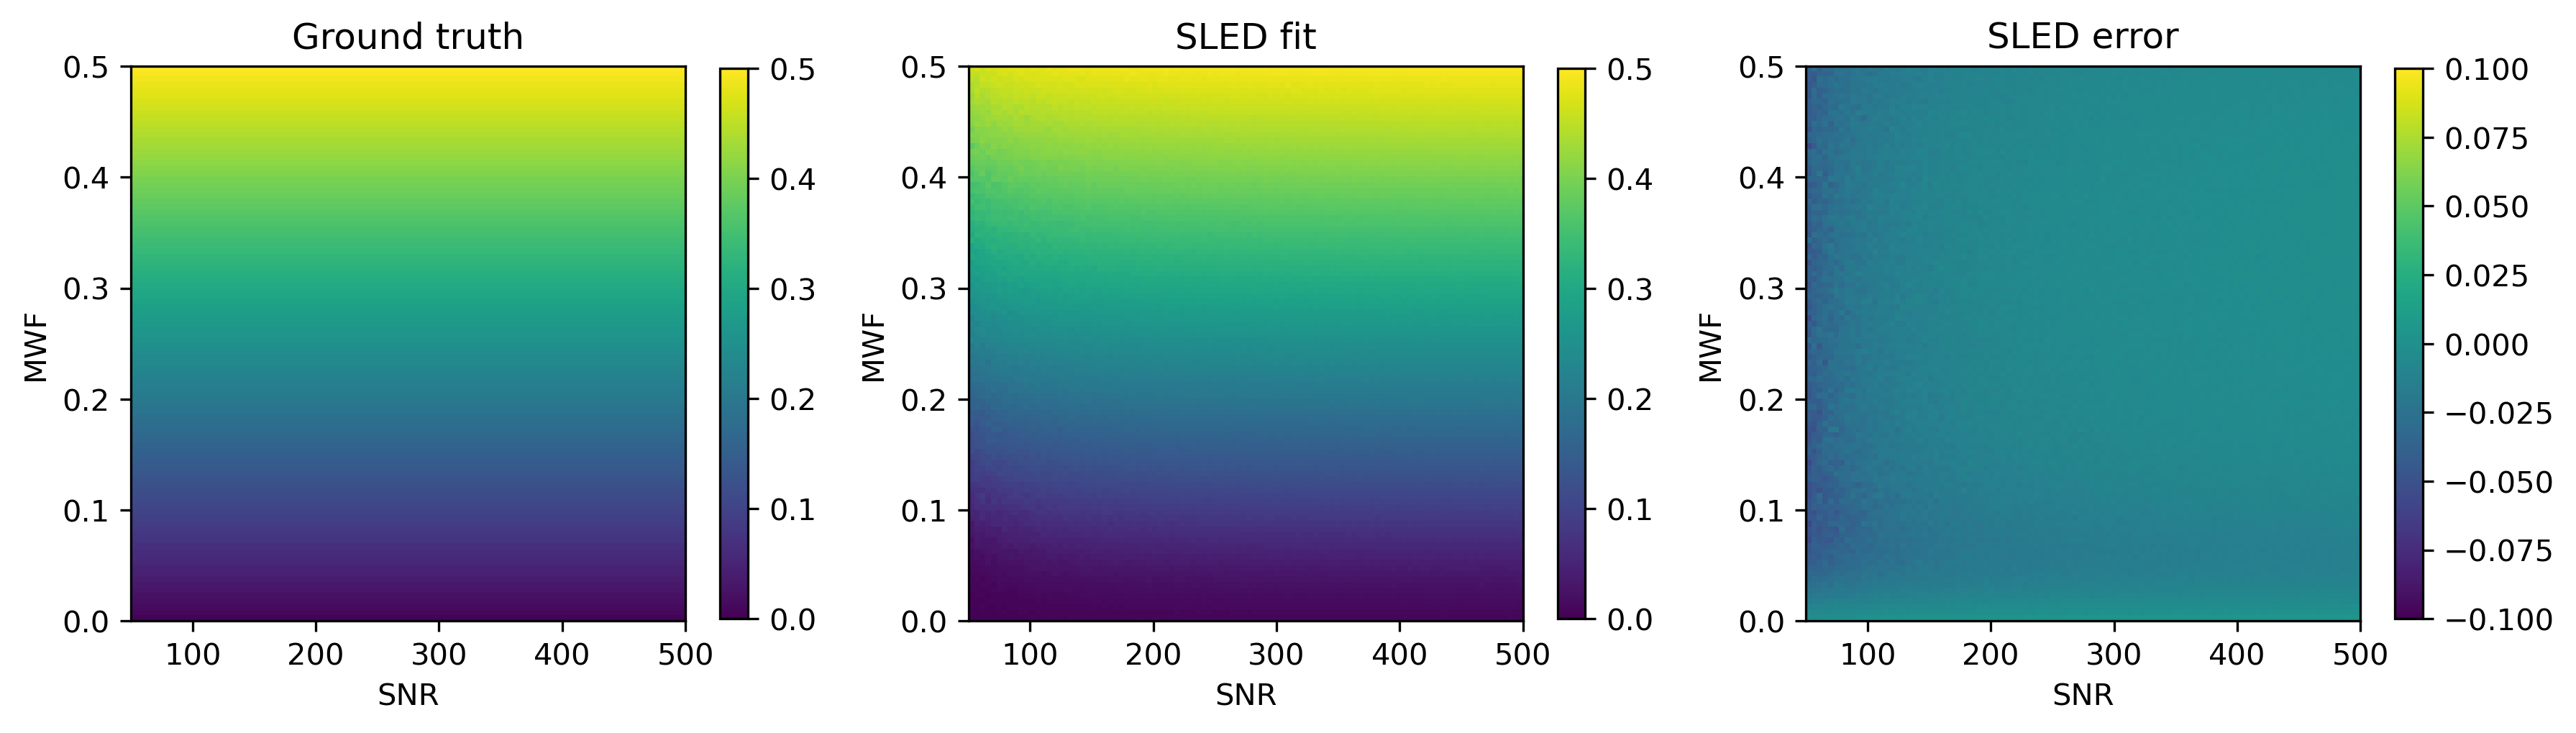

In [35]:
i = 50
plt.figure(figsize=(12, 4), dpi=300)
plt.subplot(131)
plt.xlabel('SNR')
plt.ylabel('MWF')
plt.title('Ground truth')
plt.imshow(phantom.mwf[:,:,i], vmin=0, vmax=0.5, extent=[50, 500, 0, 0.5], aspect=900)
plt.colorbar(shrink=0.69)
plt.subplot(132)
plt.xlabel('SNR')
plt.ylabel('MWF')
plt.title('SLED fit')
plt.imshow(t2s_amp_all_vary_t2s[:,:,i,0], vmin=0, vmax=0.5, extent=[50, 500, 0, 0.5], aspect=900)
plt.colorbar(shrink=0.69)
plt.subplot(133)
plt.xlabel('SNR')
plt.ylabel('MWF')
plt.title('SLED error')
plt.imshow(t2s_amp_all_vary_t2s[:,:,i,0] - phantom.mwf[:,:,i], vmin=-0.1, vmax=0.1, extent=[50, 500, 0, 0.5], aspect=900)
plt.colorbar(shrink=0.69)
plt.tight_layout()
plt.show()

## load experimental data

In [37]:
image, mask, data = load_data('/export01/data/Hanwen/SAME-ECOS/SAME-ECOS_code/mGRE_T2star.nii', 
                              '/export01/data/Hanwen/SAME-ECOS/SAME-ECOS_code/mGRE_T2star_bet_mask.nii.gz') 

In [38]:
data.shape

(135, 106, 120, 24)

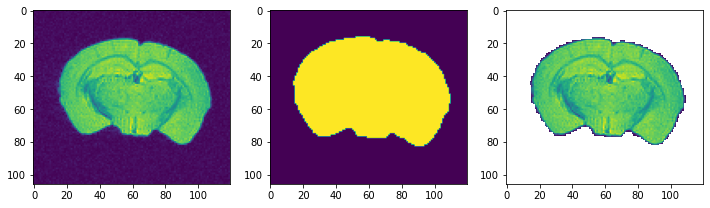

In [39]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(image[70,:,:,10])
plt.subplot(1,3,2)
plt.imshow(mask[70,:,:])
plt.subplot(1,3,3)
plt.imshow(data[70,:,:,10])
plt.show()

In [40]:
data_flat, data_flat_norm = preprocess_data(data)

## 3-pool model with variable T2s

In [61]:
def encoder_constructor_vary_t2s(latent_dim, TE, scale_factor_t2_amp, signal_model):
    
    # initilize the input layer for encoder
    keras.backend.clear_session()
    encoder_input = keras.Input(shape=(TE.shape[0],)) 

    
    # t2_loc encoding for myelin water pool
    t2s_loc_my = layers.Dense(256, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(encoder_input)
    layers.BatchNormalization()
    t2s_loc_my = layers.Dense(128, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_loc_my)
    t2s_loc_my = layers.Dense(1, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_loc_my)*0.01+0.005
    # t2_loc encoding for axnoal water pool
    t2s_loc_ax = layers.Dense(256, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(encoder_input)
    layers.BatchNormalization()
    t2s_loc_ax = layers.Dense(128, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_loc_ax)
    t2s_loc_ax = layers.Dense(1, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_loc_ax)*0.015 + 0.045
    # t2_loc encoding for free water pool
    t2s_loc_ex = layers.Dense(256, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(encoder_input)
    layers.BatchNormalization()
    t2s_loc_ex = layers.Dense(128, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_loc_ex)
    t2s_loc_ex = layers.Dense(1, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_loc_ex)*0.1 + 0.2
    
    t2s_loc = tf.concat([t2s_loc_my, t2s_loc_ax, t2s_loc_ex],1)
    
    # t2_amp encoding
    t2s_amp = layers.Dense(256, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(encoder_input)
    layers.BatchNormalization()
#     t2s_amp = layers.Dense(256, activation='sigmoid', 
#                            kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_amp)
#     layers.BatchNormalization()
    t2s_amp = layers.Dense(256, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_amp)
    t2s_amp = layers.Dense(latent_dim, activation='sigmoid', 
                           kernel_initializer = tf.keras.initializers.lecun_normal(seed=None))(t2s_amp)*scale_factor_t2_amp
    
    # construct the model
    encoder = keras.Model(encoder_input, [t2s_loc, t2s_amp], name='encoder')
    output = layers.Lambda(signal_model)([t2s_loc, t2s_amp, TE])
    model = keras.Model(encoder_input, output, name='encoder_decoder')
    
    return encoder, model

In [62]:
latent_dim = 3 # define the latent space dimension
TE = tf.range(0.002, 0.05, 0.002, dtype=float) 
scale_factor_t2_amp = 8 # default maximal amplitude is 1

In [63]:
encoder_vary_t2s, model_vary_t2s = encoder_constructor_vary_t2s(latent_dim, TE, scale_factor_t2_amp, signal_model_vpools)

In [64]:
model_vary_t2s.summary()

Model: "encoder_decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          6400        input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 256)          6400        input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          6400        input_1[0][0]                    
____________________________________________________________________________________

In [65]:
train_model(model_vary_t2s, data_flat)

Epoch 1/30
1533/1533 [==============================] - 6s 3ms/step - loss: 0.2326
Epoch 2/30
1533/1533 [==============================] - 5s 3ms/step - loss: 0.0338
Epoch 3/30
1533/1533 [==============================] - 5s 3ms/step - loss: 0.0301
Epoch 4/30
1533/1533 [==============================] - 5s 3ms/step - loss: 0.0293
Epoch 5/30
1533/1533 [==============================] - 5s 3ms/step - loss: 0.0289
Epoch 6/30
1533/1533 [==============================] - 5s 3ms/step - loss: 0.0285
Epoch 7/30
1533/1533 [==============================] - 5s 3ms/step - loss: 0.0283
Epoch 8/30
1533/1533 [==============================] - 5s 3ms/step - loss: 0.0280
Epoch 9/30
1533/1533 [==============================] - 5s 3ms/step - loss: 0.0279
Epoch 10/30
1533/1533 [==============================] - 5s 3ms/step - loss: 0.0279
Epoch 11/30
1533/1533 [==============================] - 5s 3ms/step - loss: 0.0278
Epoch 12/30
1533/1533 [==============================] - 5s 3ms/step - loss: 0.0278
E

In [67]:
t2s_loc_all_vary_t2s, t2s_amp_all_vary_t2s = apply_encoder(encoder_vary_t2s, data, latent_dim=3)

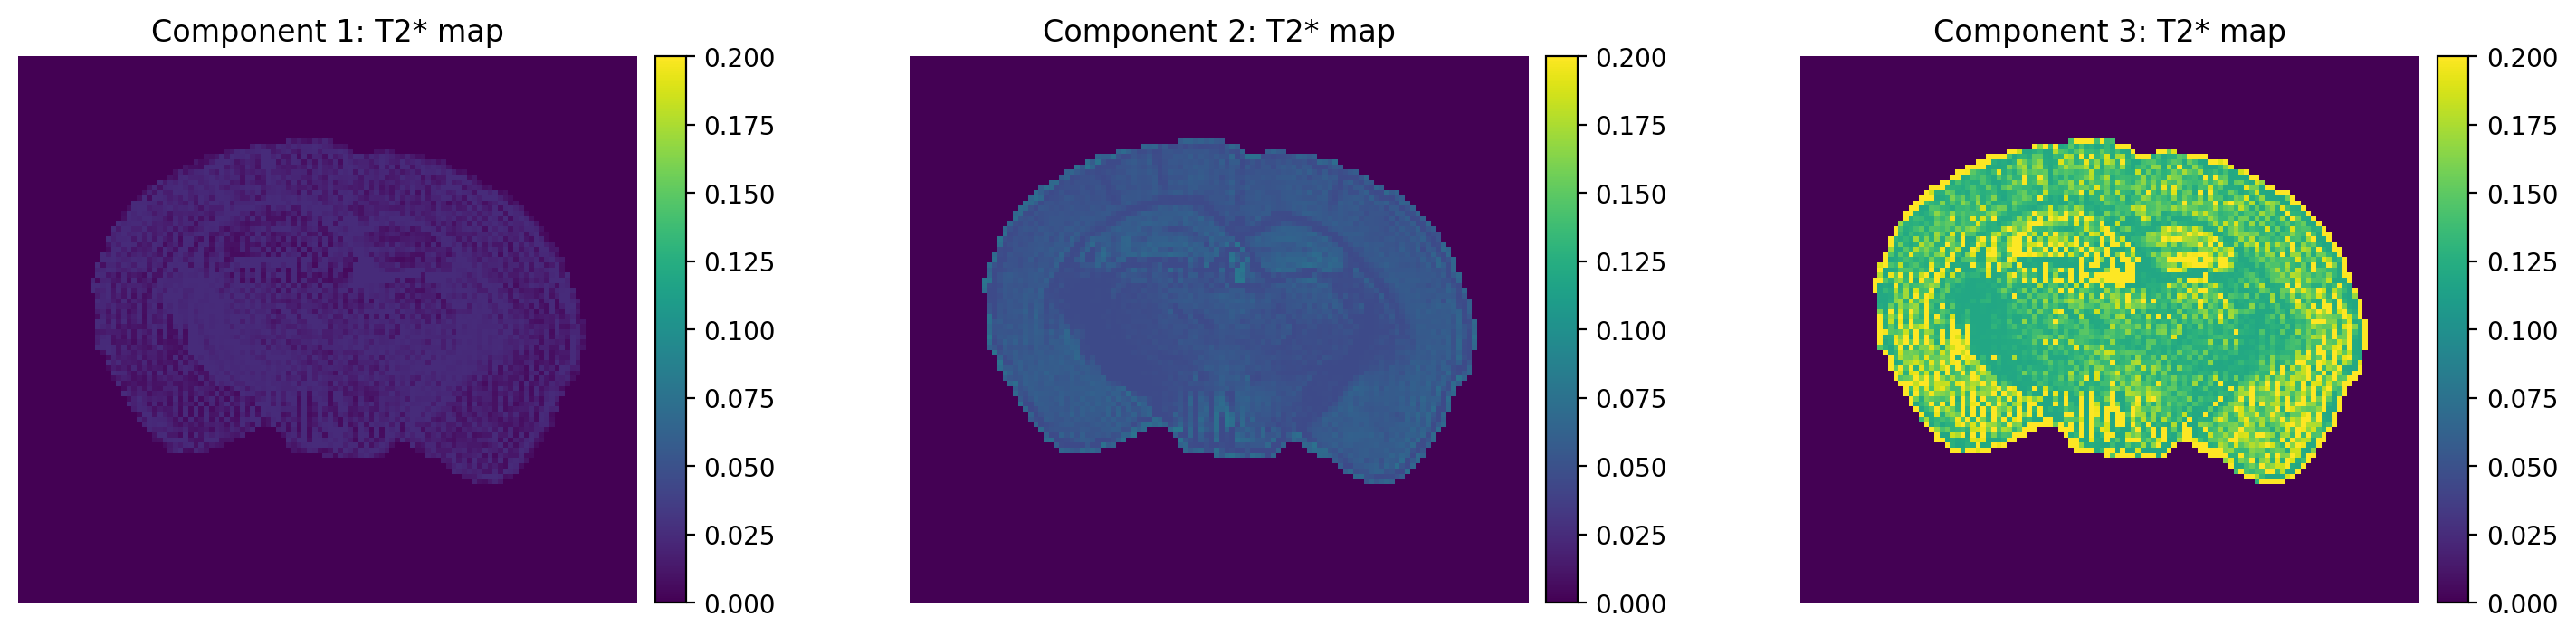

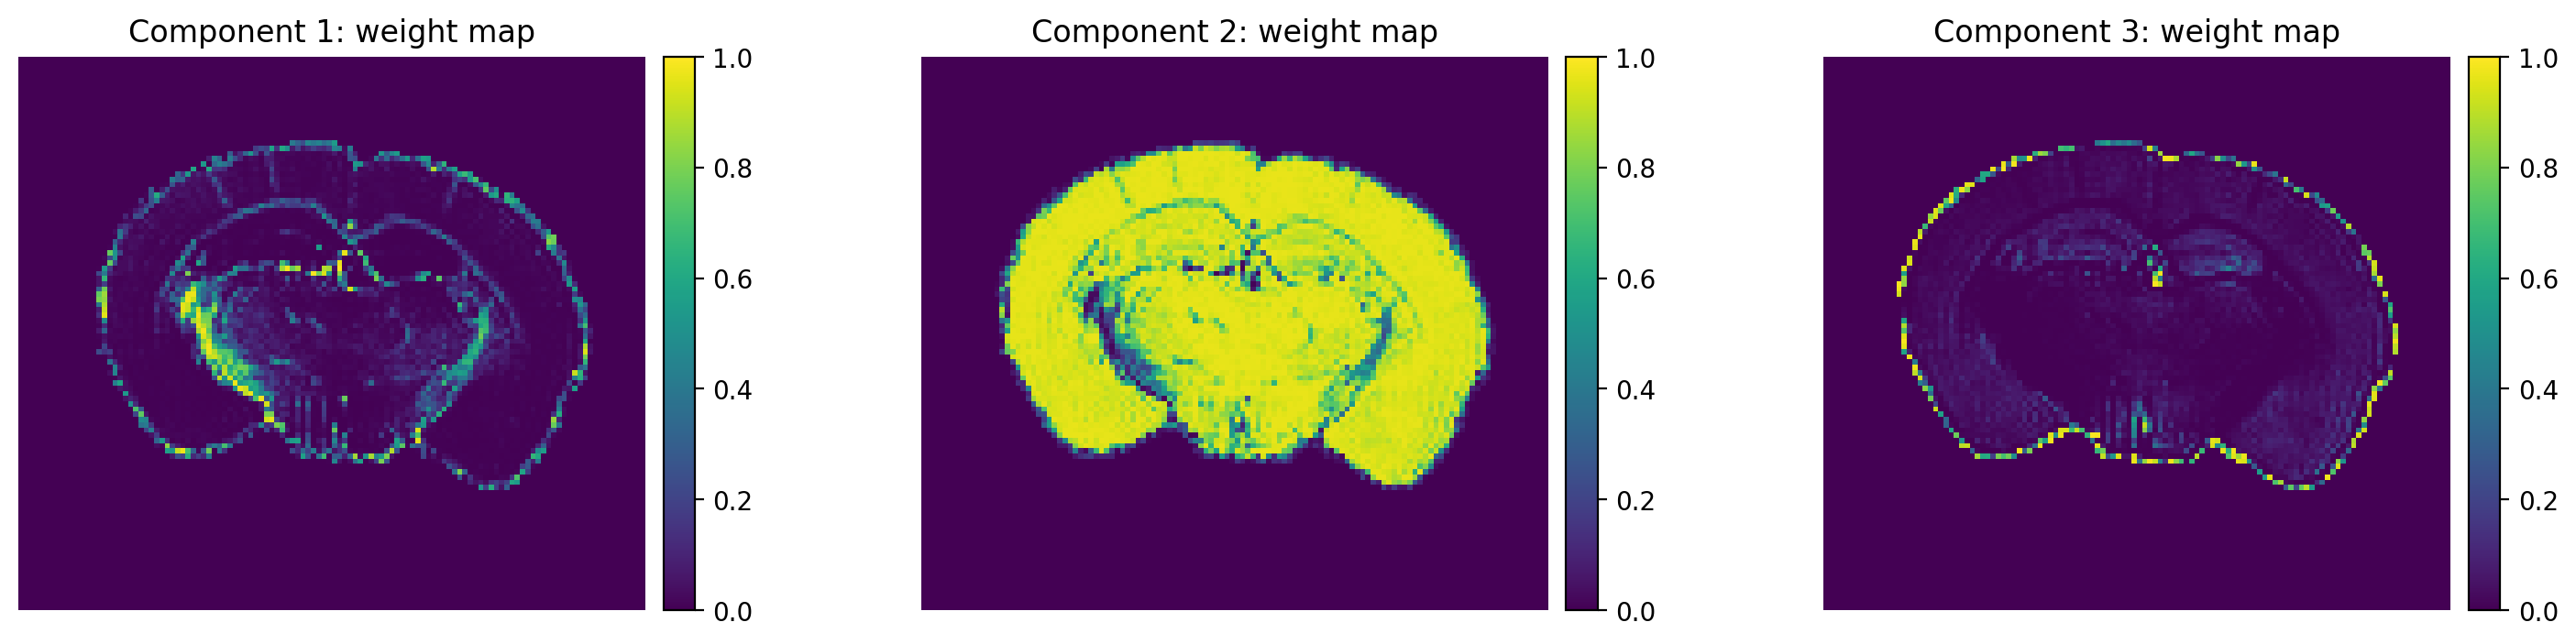

In [152]:
show_image(t2s_loc_all_vary_t2s, label='T2* map', view_slice=70, vrange=[0, 0.2],size=(18,4))
show_image(t2s_amp_all_vary_t2s, label='weight map', view_slice=70, vrange=[0, 1],size=(18,4))